# Training and Testing by Experiments

We have the set of 1946 images form 16 experiments. Some of images are very similar. Usially, images from the same experiment have low variance. It means that we have "grouped data" and we want to be sure that the same group is not represented in both testing and training sets. 

http://scikit-learn.org/stable/modules/cross_validation.html#group-cv

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
import random

from os import listdir
from os.path import isfile, join

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

import csv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

import yaml
from sklearn.model_selection import LeavePGroupsOut

In [2]:
df_work = pd.read_csv('labels_and_features_by_experiments.csv')
df_work.head(3)

,experiment,name,q_Imax,Imax_over_Imean,Imax_sharpness,logI_fluctuation,logI_max_over_std,bad_data,form,precursor,structure,str_label
0,R1,R1_1stcool_0001_dz_bgsub,0.04,18.752705,1.039870,5.330748,3.075002,False,True,False,False,form_
1,R1,R1_1stcool_0002_dz_bgsub,0.04,18.734222,1.038783,4.951954,3.026496,False,True,False,False,form_
2,R1,R1_1stcool_0003_dz_bgsub,0.04,18.700700,1.038475,4.222822,3.196090,False,True,False,False,form_


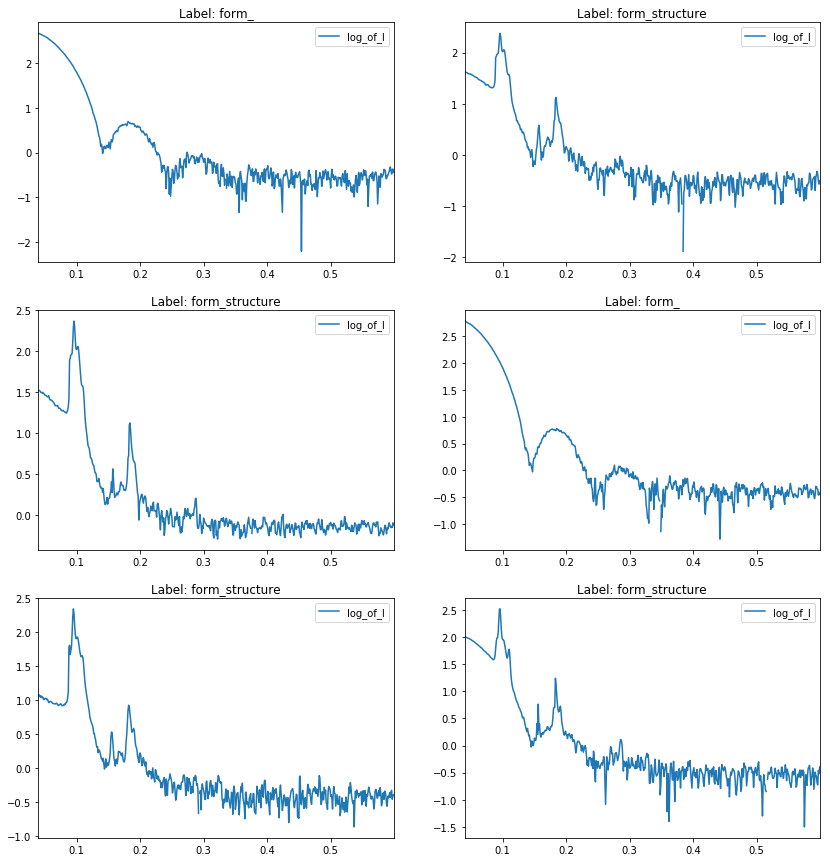

In [10]:
experiments = ['R1','R12','R13','R2','R3','R4','R5','R6','R7','Reaction_A','Reaction_B',
               'Reaction_C','Reaction_D','Reaction_E','Reaction_G','Reaction_H']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))

for n in range(6): 
    d = df_work[df_work['experiment'] == 'R12']
    size_cl = len(d)
    r_n = random.randint(0,size_cl-1)
    file_name = d.iloc[r_n, 1]
    str_label = d.iloc[r_n, -1]
    df_v = pd.read_csv('../2016_saxs_data/R12/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    axes[n%3, n%2].set_title("Label: " + str_label);
    axes[n%3, n%2].xaxis.label.set_visible(False) 

### I will not use the images form the same experimnent in training and testing. 

Since we have few data, I am going to use cross validation by experiments. For example, to train the model on the experinent 1-13 and test on 14-16. Then train on 2-14 and test on 1, 15, and 16...

## Data Distribution: all data

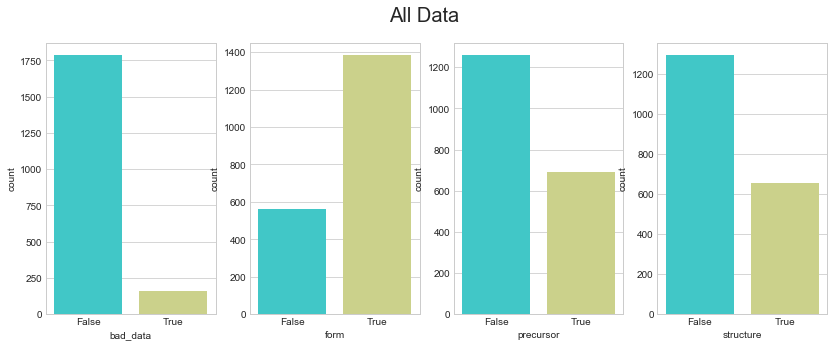

In [17]:
branches = ['bad_data', 'form', 'precursor', 'structure']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14,5))
st = fig.suptitle("All Data", fontsize=20)
for n in range(4): # max number of classes is 9, but we have only 6 now
    br = branches[n]
    sns.countplot(x=br, data=df_work, palette='rainbow', ax=axes[n])

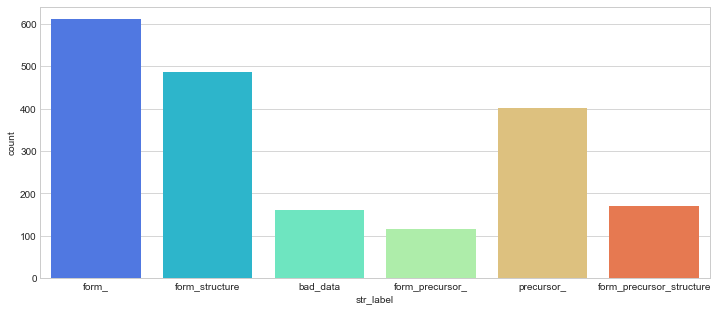

In [12]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(12,5))
sns.countplot(data=df_work, x='str_label',palette='rainbow')

## Data Distribution by Experiments

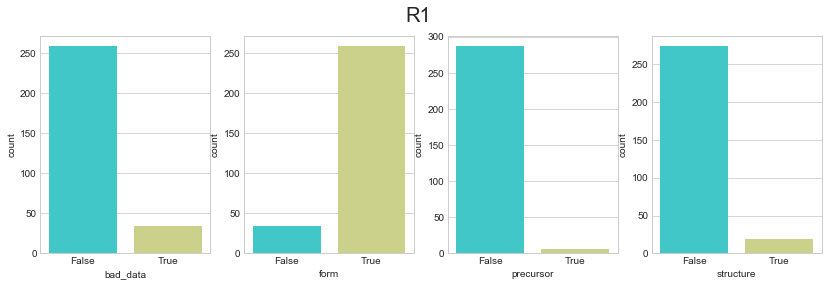

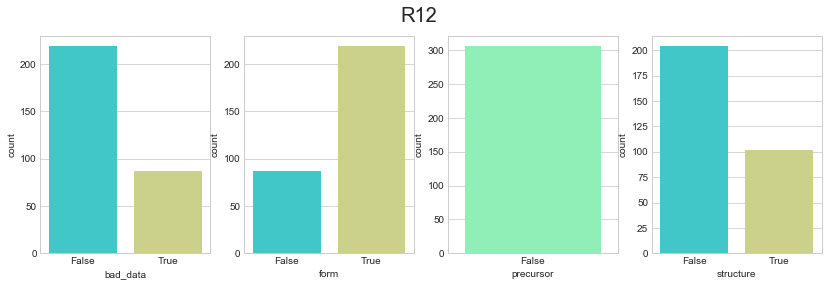

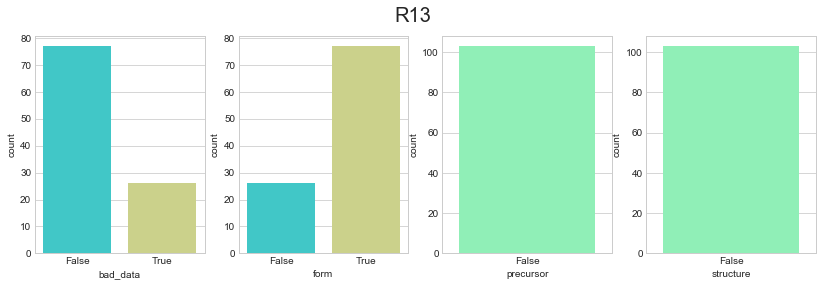

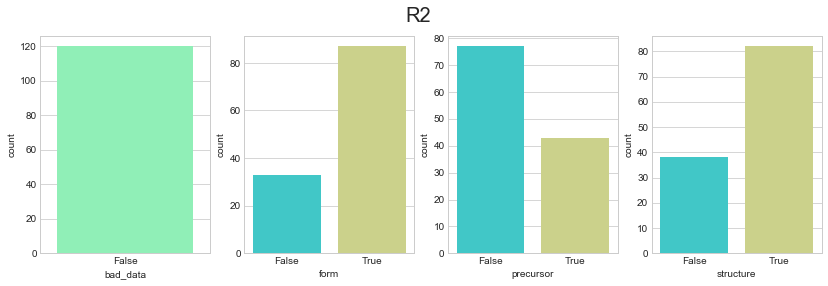

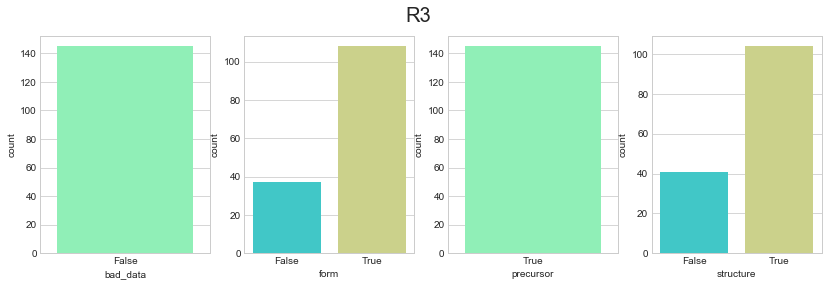

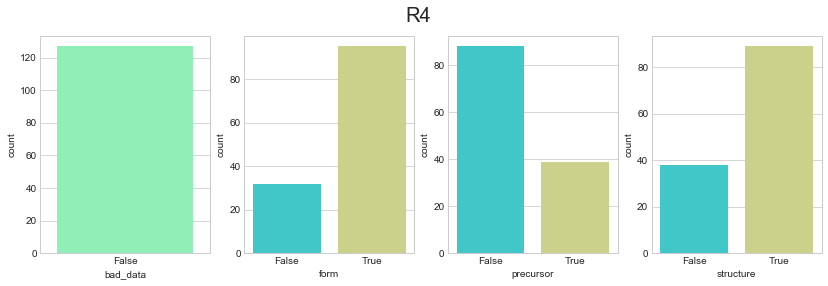

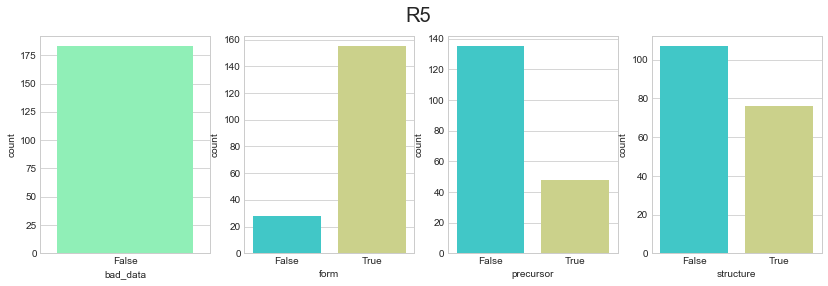

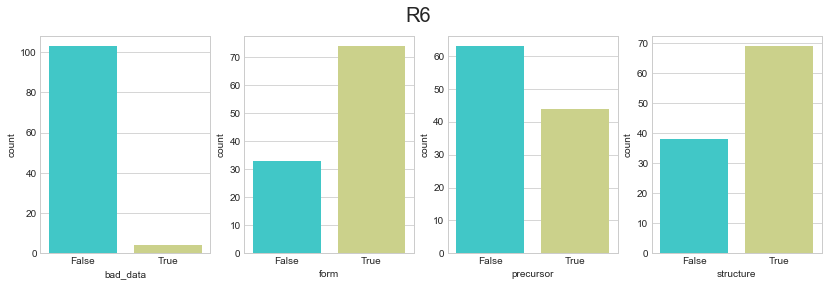

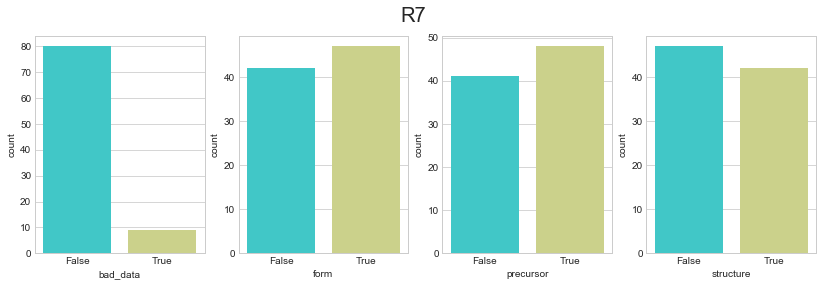

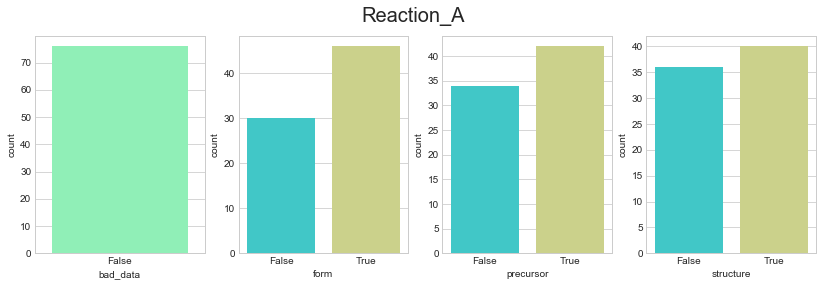

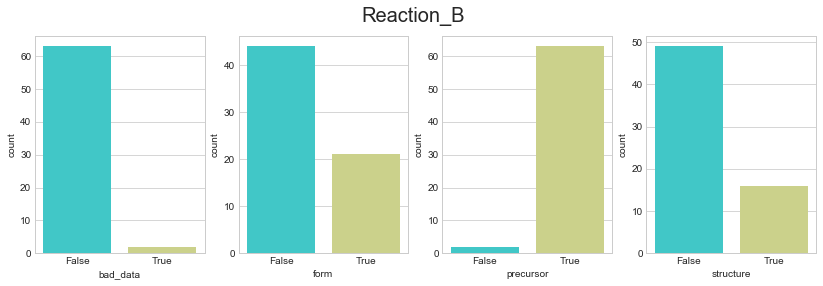

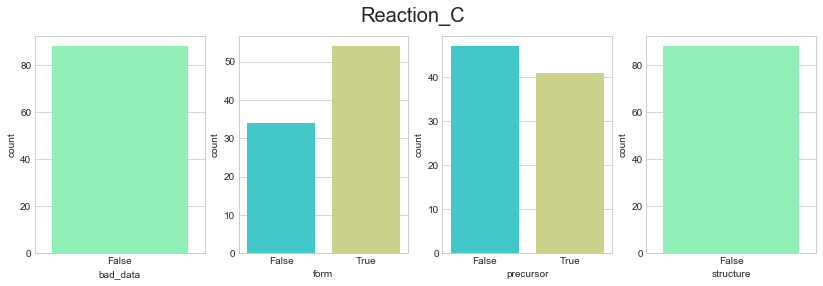

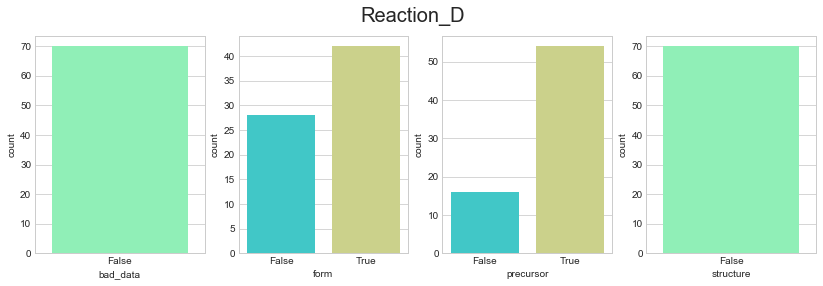

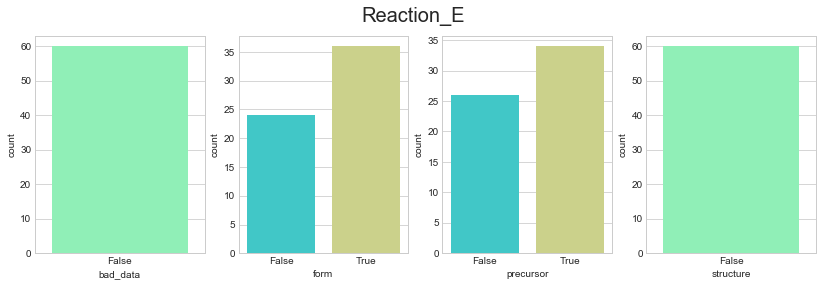

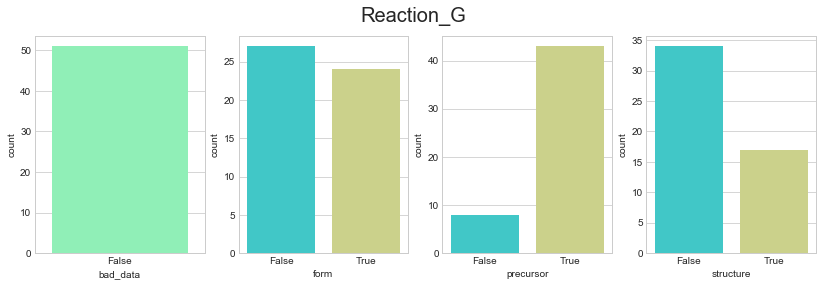

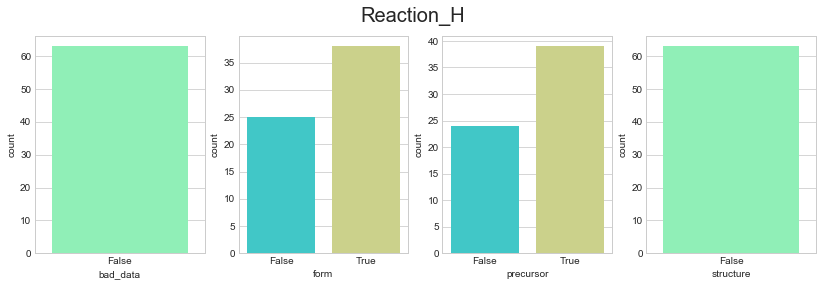

In [20]:
for expr in experiments:
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14,4))
    st = fig.suptitle(expr, fontsize=20)
    for n in range(4): # max number of classes is 9, but we have only 6 now
        br = branches[n]
        d = df_work[df_work['experiment'] == expr]
        sns.countplot(x=br, data=d, palette='rainbow', ax=axes[n])

In [67]:
shuffled_rows = np.random.permutation(df_work.index)
df_work = df_work.loc[shuffled_rows]

In [69]:
train = df_work.iloc[ : 1746]
hold_out = df_work.iloc[1746: ]

In [70]:
train.shape

(1746, 12)

In [71]:
hold_out.shape

(200, 12)

In [72]:
# I want to save the split and use it late for testing of unsupervised models
train.to_pickle('train_by_exp.pkl')
hold_out.to_pickle('hold_out_by_exp.pkl')

In [151]:
train = pd.read_pickle('train_by_exp.pkl')
hold_out = pd.read_pickle('hold_out_by_exp.pkl')

In [152]:
features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

sklearn.linear_model.SGDClassifier can works as **Logistic Regression**, linesr **SVM**, and **Perceptron** depending on the "loss" parametr.

I choose this classifier since it has the **partial_fit** method.It allows us to update the model using only some new data.

This estimator implements regularized linear models with stochastic gradient descent learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing learning rate. 

For best results the data should have zero mean and unit variance (we need to use a scaler).

**StandardScaler** "standardize features by removing the mean and scaling to unit variance
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using the transform method.
Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).
For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected."
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [153]:
# parameters for SGDClassifier()
# loss= log    -> logistic regression
# loss = hinge -> linear SVM
# loss = perceptron -> perceptron
parameters = {'loss':('hinge', 'log', 'perceptron'), #default hinge
              'penalty':('none', 'l2', 'l1', 'elasticnet'), #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.95], #default 0.15
             }

In [154]:
# only logistic regression
parameters2 = {'penalty':('none', 'l2', 'l1', 'elasticnet'), #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.95], #default 0.15
             }

## Bad Data

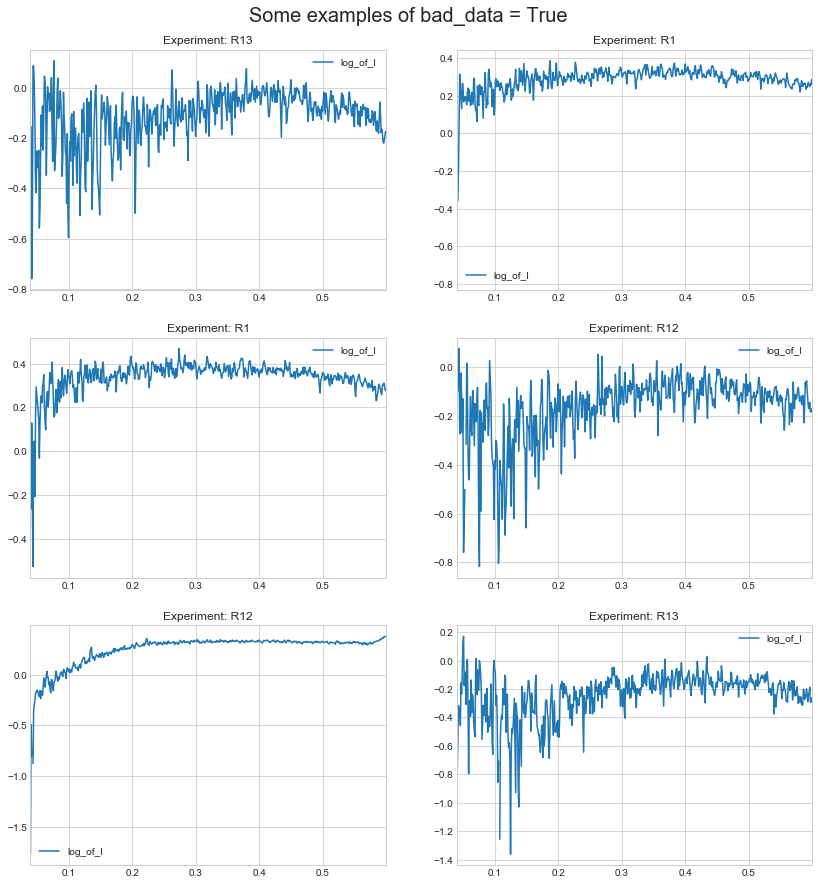

In [53]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))
st = fig.suptitle("Some examples of bad_data = True", fontsize=20)
st.set_y(0.92)
#fig.tight_layout()

for n in range(6): 
    d = train[train['bad_data'] == True]
    size_cl = len(d)
    r_n = random.randint(0,size_cl-1)
    file_name = d.iloc[r_n, 1]
    ex = d.iloc[r_n, 0]
    df_v = pd.read_csv('../2016_saxs_data/'+ ex + '/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    axes[n%3, n%2].set_title("Experiment: " + ex);
    axes[n%3, n%2].xaxis.label.set_visible(False)  

### Using GridSearchCV() for choosing the best parametrs and best feature set for "bad_data" labels:

In [155]:
cv=LeavePGroupsOut(n_groups=2).split(train[features], train[['bad_data']], groups=train['experiment'])

In [156]:
scaler = preprocessing.StandardScaler()
scaler.fit(train[features])
svc = linear_model.SGDClassifier(loss = 'log')
clf = GridSearchCV(svc, parameters2, cv=cv)
    
clf.fit(scaler.transform(train[features]), train['bad_data'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.001, 'l1_ratio': 0.95, 'penalty': 'elasticnet'}
Training score:  0.968


**Let's check how this model works for different experiments**

In [157]:
test_scores_by_ex = []
training_score = []
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        print("Testing on: ", experiments[i], 'and', experiments[j])
        tr = train[(train['experiment']!= experiments[i]) & (train['experiment']!= experiments[j])]
        test = train[(train['experiment']== experiments[i]) | (train['experiment']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0.95, penalty= 'elasticnet')

        scores = cross_val_score(log, scaler.transform(tr[features]), tr['bad_data'], cv=5)
        print("cross validation score: ", scores.mean())
        training_score.append(scores.mean())

        log.fit(scaler.transform(tr[features]), tr['bad_data'])
        test_score = log.score(scaler.transform(test[features]), test['bad_data'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        count +=1
        print()
        
print("Average training score: ", sum(training_score)/count)
print("Average testing score: ", sum(test_scores_by_ex)/count)

Testing on:  R1 and R12
cross validation score:  0.991690814215
test score:  0.939114391144

Testing on:  R1 and R13
cross validation score:  0.987050192151
test score:  0.935574229692

Testing on:  R1 and R2
cross validation score:  0.986168450612
test score:  0.943699731903

Testing on:  R1 and R3
cross validation score:  0.985969559205
test score:  0.94387755102

Testing on:  R1 and R4
cross validation score:  0.984674109346
test score:  0.941489361702

Testing on:  R1 and R5
cross validation score:  0.986274054509
test score:  0.951724137931

Testing on:  R1 and R6
cross validation score:  0.98918256699
test score:  0.935754189944

Testing on:  R1 and R7
cross validation score:  0.989313621564
test score:  0.906432748538

Testing on:  R1 and Reaction_A
cross validation score:  0.989399222692
test score:  0.936555891239

Testing on:  R1 and Reaction_B
cross validation score:  0.985955028416
test score:  0.934782608696

Testing on:  R1 and Reaction_C
cross validation score:  0.984341

test score:  0.953020134228

Testing on:  R7 and Reaction_A
cross validation score:  0.976861199816
test score:  0.986394557823

Testing on:  R7 and Reaction_B
cross validation score:  0.977608695652
test score:  0.985507246377

Testing on:  R7 and Reaction_C
cross validation score:  0.97986026358
test score:  0.974522292994

Testing on:  R7 and Reaction_D
cross validation score:  0.975073914978
test score:  0.978723404255

Testing on:  R7 and Reaction_E
cross validation score:  0.977735651346
test score:  0.953488372093

Testing on:  R7 and Reaction_G
cross validation score:  0.974167059934
test score:  0.983333333333

Testing on:  R7 and Reaction_H
cross validation score:  0.975193655732
test score:  0.924812030075

Testing on:  Reaction_A and Reaction_B
cross validation score:  0.975908549655
test score:  1.0

Testing on:  Reaction_A and Reaction_C
cross validation score:  0.97562491455
test score:  1.0

Testing on:  Reaction_A and Reaction_D
cross validation score:  0.97586850996
t

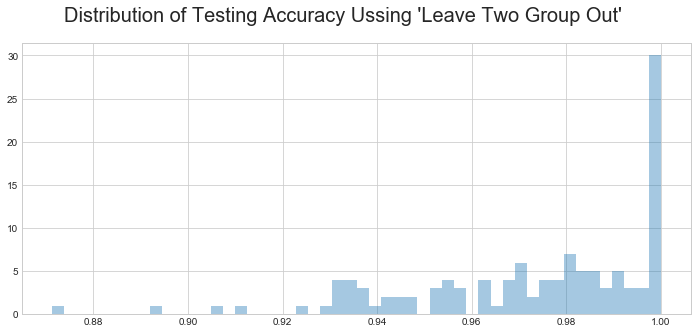

In [158]:
plt.figure(figsize=(12,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy Ussing 'Leave Two Group Out' ", fontsize=20)

In [159]:
# we need to save the version of sklearn to use in PAWS
current_version = list(map(int,sklearn.__version__.split('.')))
major,minor,patch = current_version
current_version

[0, 19, 0]

In [160]:
# I am saving version of sklearn with all scalers and models. 
# Then I will dump them into a yaml file that will be used in PAWS app.
scalers = {} 
models = {}
scalers_and_models = {'version':current_version, 'scalers' : scalers, 'models': models}

In [172]:
scaler = preprocessing.StandardScaler()
scaler.fit(train[features])
log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0.95, penalty= 'elasticnet')

#train the model on all training data and test on "hold out" data
log.fit(scaler.transform(train[features]), train['bad_data'])
hold_out_score = log.score(scaler.transform(hold_out[features]), hold_out['bad_data'])
print("hold out score: ", hold_out_score)

hold out score:  0.97


In [173]:
hold_out['bad_data_pred'] = log.predict(scaler.transform(hold_out[features]))

pr = log.predict_proba(scaler.transform(hold_out[features]))[ : , 1]
formated_pr = list(map(lambda x: "{0:.5f}".format(x), pr))

hold_out['bad_data_prob_true'] =  pd.to_numeric(formated_pr)

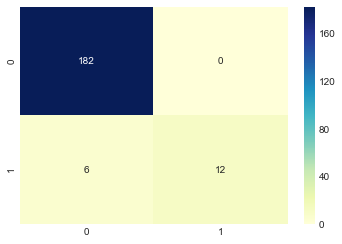

In [174]:
cnf_matrix = confusion_matrix(hold_out['bad_data'], hold_out['bad_data_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g', cmap="YlGnBu")

**We have 5 false negative.**

In [175]:
difference = hold_out[hold_out['bad_data'] != hold_out['bad_data_pred']]
difference[['experiment','name', 'str_label','bad_data','bad_data_pred', 'bad_data_prob_true']]

,experiment,name,str_label,bad_data,bad_data_pred,bad_data_prob_true
233,R1,R1_reac_0026_dz_bgsub,bad_data,True,False,0.04611
212,R1,R1_reac_0005_dz_bgsub,bad_data,True,False,0.12408
1391,R7,R7_cool_0008_dz_bgsub,bad_data,True,False,0.15647
209,R1,R1_reac_0002_dz_bgsub,bad_data,True,False,0.45158
462,R12,R12cooling2rd_0055_dz_bgsub,bad_data,True,False,0.00034
1380,R6,R6_SAXS_0001_dz_bgsub,bad_data,True,False,0.01978


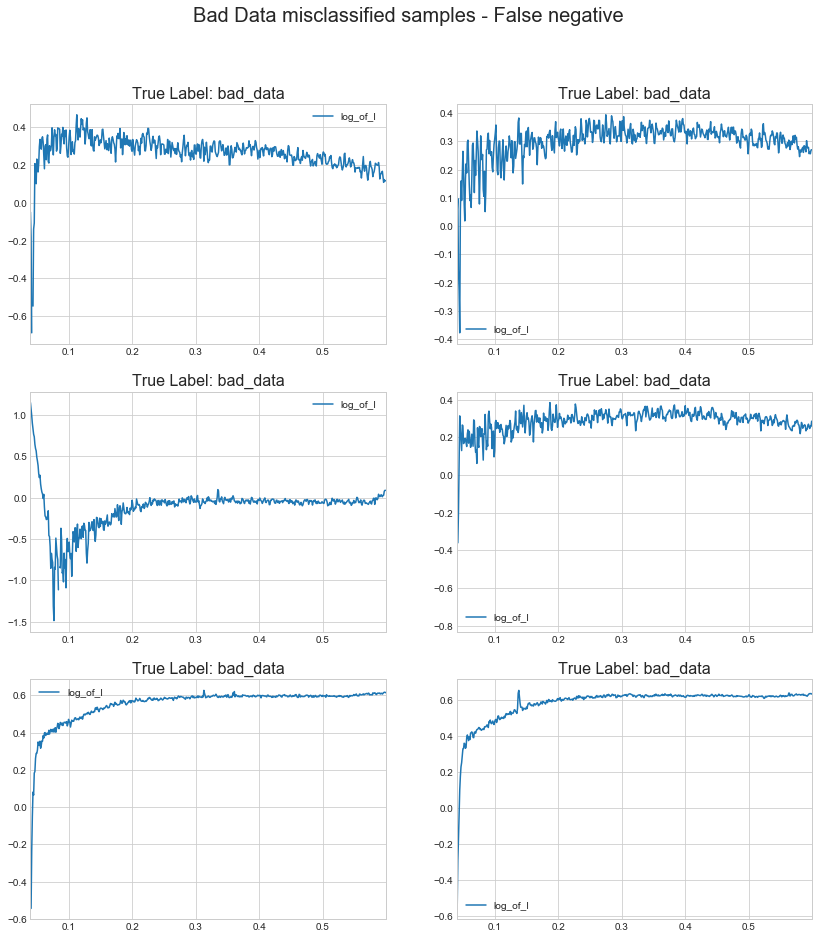

In [176]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))
st = fig.suptitle("Bad Data misclassified samples - False negative", fontsize=20)
st.set_y(0.97)

for n in range(len(difference)): 
    d = difference.iloc[n]
    ex = d.iloc[0]
    file_name = d.iloc[1]
    str_label = difference.iloc[n]['str_label']
    df_v = pd.read_csv('../2016_saxs_data/' + ex + '/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    axes[n%3, n%2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%3, n%2].xaxis.label.set_visible(False)

In [177]:
# to train the model on all avalible data 
all_data = train.append(hold_out)
scaler = preprocessing.StandardScaler()
scaler.fit(all_data[features])
log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0.95, penalty= 'elasticnet')
log.fit(scaler.transform(all_data[features]), all_data['bad_data'])

# save the scaler and model
scalers['bad_data'] = scaler.__dict__
models['bad_data'] = log.__dict__

### Now we will use only samples that have label "bad_data" : False

In [178]:
#now we need only "good" data
train_good = train[train['bad_data']==False]
train_good.shape

(1602, 12)

In [179]:
test_good = hold_out[hold_out['bad_data_pred']==False]
test_good.shape

(188, 14)

## Form Label
### I am using GridSearchCV() again for choosing the best parametrs and best feature set for "form" labels. 

Since Logistic Regression has partial_fit() and predict_prop() I will try to get a good result using only logistic Regression.

In [180]:
cv=LeavePGroupsOut(n_groups=2).split(train_good[features], train_good[['form']], groups=train_good['experiment'])

In [181]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
clf = GridSearchCV(svc, parameters2, cv=cv)
    
clf.fit(scaler.transform(train_good[features]), train_good['form'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'l1_ratio': 0.5, 'penalty': 'l1'}
Training score:  0.983


In [182]:
test_scores_by_ex = []
training_score = []
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        print("Testing on: ", experiments[i], 'and', experiments[j])
        tr = train_good[(train_good['experiment']!= experiments[i]) & (train_good['experiment']!= experiments[j])]
        test = train_good[(train['experiment']== experiments[i]) | (train_good['experiment']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.0001,loss= 'log', l1_ratio= 0.5, penalty= 'l1')

        scores = cross_val_score(log, scaler.transform(tr[features]), tr['form'], cv=5)
        print("cross validation score: ", scores.mean())
        training_score.append(scores.mean())

        log.fit(scaler.transform(tr[features]), tr['form'])
        test_score = log.score(scaler.transform(test[features]), test['form'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        count +=1
        print()
        
print("Average training score: ", sum(training_score)/count)
print("Average testing score: ", sum(test_scores_by_ex)/count)

Testing on:  R1 and R12
cross validation score:  0.974344238137
test score:  1.0

Testing on:  R1 and R13
cross validation score:  0.983041213971
test score:  1.0

Testing on:  R1 and R2
cross validation score:  0.980898627711
test score:  0.988405797101

Testing on:  R1 and R3
cross validation score:  0.976557319785
test score:  0.991758241758

Testing on:  R1 and R4
cross validation score:  0.972098728894
test score:  0.997126436782

Testing on:  R1 and R5
cross validation score:  0.964065228602
test score:  0.997542997543

Testing on:  R1 and R6
cross validation score:  0.978011400919
test score:  0.990853658537

Testing on:  R1 and R7
cross validation score:  0.981482031482
test score:  0.993464052288

Testing on:  R1 and Reaction_A
cross validation score:  0.976899203106
test score:  0.996699669967

Testing on:  R1 and Reaction_B
cross validation score:  0.980161334787
test score:  0.986301369863

Testing on:  R1 and Reaction_C
cross validation score:  0.982167526317
test score:  

test score:  0.982456140351

Testing on:  R6 and Reaction_D
cross validation score:  0.982722743433
test score:  0.993548387097

Testing on:  R6 and Reaction_E
cross validation score:  0.979440189814
test score:  0.972027972028

Testing on:  R6 and Reaction_G
cross validation score:  0.982969900289
test score:  0.985074626866

Testing on:  R6 and Reaction_H
cross validation score:  0.984192407397
test score:  0.986394557823

Testing on:  R7 and Reaction_A
cross validation score:  0.98017193859
test score:  0.978417266187

Testing on:  R7 and Reaction_B
cross validation score:  0.984402167647
test score:  0.9609375

Testing on:  R7 and Reaction_C
cross validation score:  0.979343524114
test score:  0.96644295302

Testing on:  R7 and Reaction_D
cross validation score:  0.965953890088
test score:  0.984962406015

Testing on:  R7 and Reaction_E
cross validation score:  0.983801983802
test score:  0.95041322314

Testing on:  R7 and Reaction_G
cross validation score:  0.983214576386
test sco

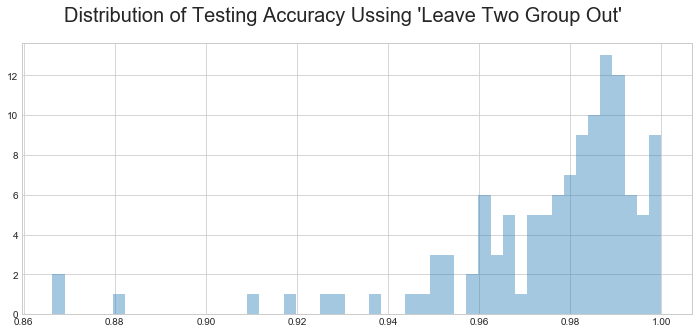

In [183]:
plt.figure(figsize=(12,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy Ussing 'Leave Two Group Out' ", fontsize=20)

In [184]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0, penalty= 'none')

log.fit(scaler.transform(train_good[features]), train_good['form'])
hold_out_score = log.score(scaler.transform(test_good[features]), test_good['form'])
print("hold out score: ", hold_out_score)

hold out score:  0.994680851064


In [185]:
test_good['form_pred'] = log.predict(scaler.transform(test_good[features]))

pr = log.predict_proba(scaler.transform(test_good[features]))[ : , 1]
formated_pr = list(map(lambda x: "{0:.16f}".format(x), pr))

test_good['form_prob_true'] = pd.to_numeric(formated_pr)

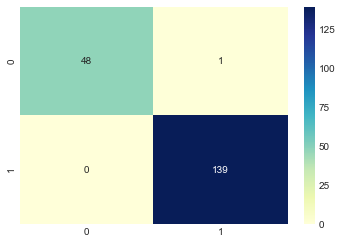

In [186]:
cnf_matrix = confusion_matrix(test_good['form'], test_good['form_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g', cmap="YlGnBu")

**We have two false positive**

In [187]:
difference = test_good[test_good['form'] != test_good['form_pred']]
difference[['experiment','name', 'str_label','form','form_pred', 'form_prob_true']]

,experiment,name,str_label,form,form_pred,form_prob_true
462,R12,R12cooling2rd_0055_dz_bgsub,bad_data,False,True,0.999229


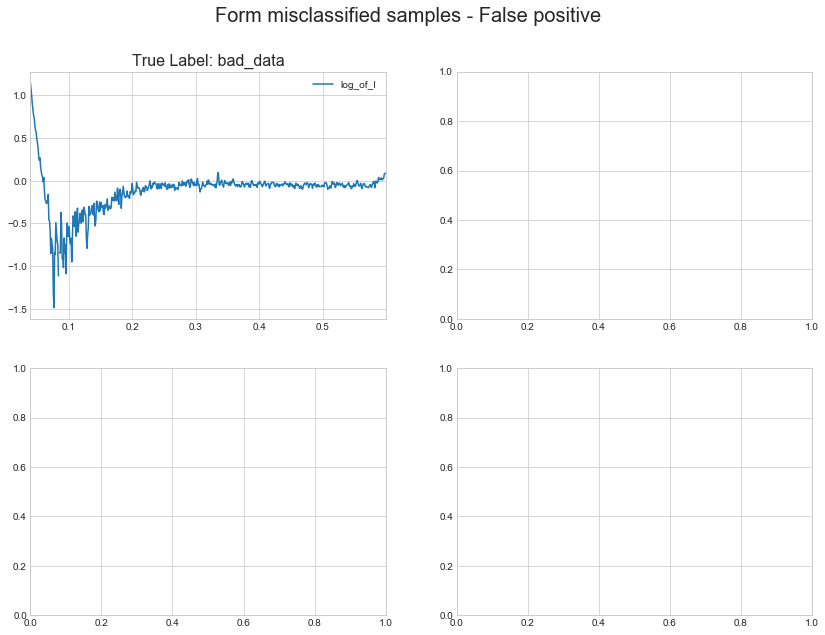

In [188]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
st = fig.suptitle("Form misclassified samples - False positive", fontsize=20)
st.set_y(0.97)

for n in range(len(difference)): 
    d = difference.iloc[n]
    ex = d.iloc[0]
    file_name = d.iloc[1]
    str_label = difference.iloc[n]['str_label']
    df_v = pd.read_csv('../2016_saxs_data/' + ex + '/'+ file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%2, n//2])
    axes[n%2, n//2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%2, n//2].xaxis.label.set_visible(False)

In [189]:
# to train the model on all avalible data 
all_data = train_good.append(hold_out[hold_out['bad_data']==False])
scaler = preprocessing.StandardScaler()
scaler.fit(all_data[features])
log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0, penalty= 'none')
log.fit(scaler.transform(all_data[features]), all_data['form'])

# save the scaler and model
scalers['form_factor_scattering'] = scaler.__dict__
models['form_factor_scattering'] = log.__dict__

## Precursor Label

In [190]:
cv=LeavePGroupsOut(n_groups=2).split(train_good[features], train_good[['precursor']], groups=train_good['experiment'])

scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
clf = GridSearchCV(svc, parameters2, cv=cv)
    
clf.fit(scaler.transform(train_good[features]), train_good['precursor'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'l1_ratio': 0, 'penalty': 'l1'}
Training score:  0.778


In [191]:
test_scores_by_ex = []
training_score = []
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        print("Testing on: ", experiments[i], 'and', experiments[j])
        tr = train_good[(train_good['experiment']!= experiments[i]) & (train_good['experiment']!= experiments[j])]
        test = train_good[(train['experiment']== experiments[i]) | (train_good['experiment']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.01,loss= 'log', l1_ratio= 0, penalty= 'l1')

        scores = cross_val_score(log, scaler.transform(tr[features]), tr['precursor'], cv=5)
        print("cross validation score: ", scores.mean())
        training_score.append(scores.mean())

        log.fit(scaler.transform(tr[features]), tr['precursor'])
        test_score = log.score(scaler.transform(test[features]), test['precursor'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        count +=1
        print()
        
print("Average training score: ", sum(training_score)/count)
print("Average testing score: ", sum(test_scores_by_ex)/count)

Testing on:  R1 and R12
cross validation score:  0.767960027067
test score:  0.896313364055

Testing on:  R1 and R13
cross validation score:  0.767166617167
test score:  0.947540983607

Testing on:  R1 and R2
cross validation score:  0.767677117616
test score:  0.872463768116

Testing on:  R1 and R3
cross validation score:  0.852948282617
test score:  0.714285714286

Testing on:  R1 and R4
cross validation score:  0.745631746032
test score:  0.936781609195

Testing on:  R1 and R5
cross validation score:  0.783239425477
test score:  0.842751842752

Testing on:  R1 and R6
cross validation score:  0.755868602362
test score:  0.917682926829

Testing on:  R1 and R7
cross validation score:  0.77621181877
test score:  0.895424836601

Testing on:  R1 and Reaction_A
cross validation score:  0.766706266706
test score:  0.927392739274

Testing on:  R1 and Reaction_B
cross validation score:  0.779389312977
test score:  0.900684931507

Testing on:  R1 and Reaction_C
cross validation score:  0.78660

Testing on:  R6 and Reaction_C
cross validation score:  0.804289736793
test score:  0.836257309942

Testing on:  R6 and Reaction_D
cross validation score:  0.806437345053
test score:  0.774193548387

Testing on:  R6 and Reaction_E
cross validation score:  0.803271665961
test score:  0.853146853147

Testing on:  R6 and Reaction_G
cross validation score:  0.801718093381
test score:  0.813432835821

Testing on:  R6 and Reaction_H
cross validation score:  0.801352348116
test score:  0.795918367347

Testing on:  R7 and Reaction_A
cross validation score:  0.80036467343
test score:  0.834532374101

Testing on:  R7 and Reaction_B
cross validation score:  0.816069924992
test score:  0.75

Testing on:  R7 and Reaction_C
cross validation score:  0.799690840557
test score:  0.651006711409

Testing on:  R7 and Reaction_D
cross validation score:  0.809996737748
test score:  0.699248120301

Testing on:  R7 and Reaction_E
cross validation score:  0.802813221542
test score:  0.793388429752

Testing on:

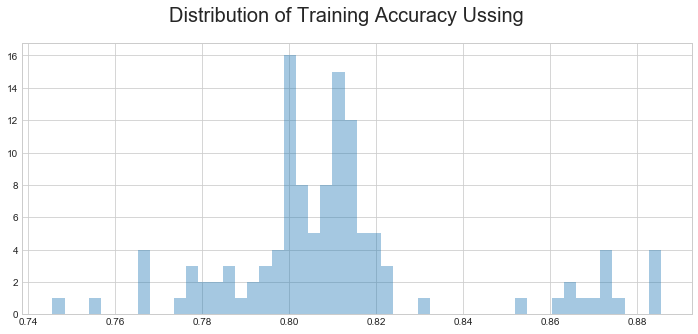

In [192]:
plt.figure(figsize=(12,5))
sns.distplot(training_score, kde=False, bins=50)
plt.suptitle("Distribution of Training Accuracy Ussing", fontsize=20)

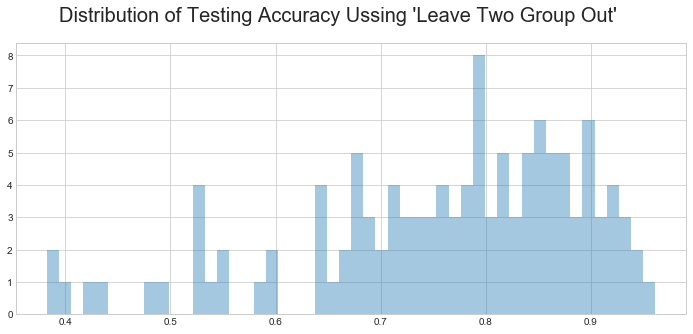

In [193]:
plt.figure(figsize=(12,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy Ussing 'Leave Two Group Out' ", fontsize=20)

In [194]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
log = linear_model.SGDClassifier(alpha= 0.01,loss= 'log', l1_ratio= 0.95, penalty= 'l1')

log.fit(scaler.transform(train_good[features]), train_good['precursor'])
hold_out_score = log.score(scaler.transform(test_good[features]), test_good['precursor'])
print("hold out score: ", hold_out_score)

hold out score:  0.765957446809


In [195]:
test_good['precursor_pred'] = log.predict(scaler.transform(test_good[features]))

pr = log.predict_proba(scaler.transform(test_good[features]))[ : , 1]
formated_pr = list(map(lambda x: "{0:.16f}".format(x), pr))

test_good['precursor_prob_true'] = pd.to_numeric(formated_pr)

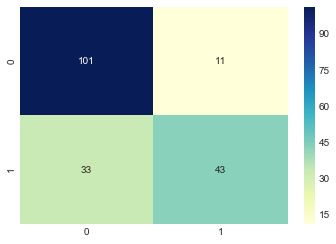

In [196]:
cnf_matrix = confusion_matrix(test_good['precursor'], test_good['precursor_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g', cmap="YlGnBu")

**We have 32 false negative and 11 false positive**

In [197]:
difference = test_good[test_good['precursor'] != test_good['precursor_pred']]
difference[['experiment','name', 'str_label','precursor','precursor_pred', 'precursor_prob_true']].head()

,experiment,name,str_label,precursor,precursor_pred,precursor_prob_true
865,R3,R3_cool_0044_dz_bgsub,form_precursor_structure,True,False,0.186123
1589,Reaction_B,B_240C_3min_0212155719_0001_dz_bgsub,form_precursor_structure,True,False,0.465565
1910,Reaction_H,H_271C_0214203651_0001_dz_bgsub,form_precursor_,True,False,0.482871
1100,R5,R5_1stcool2_0007_dz_bgsub,form_structure,False,True,0.655563
1865,Reaction_G,G_273C_0214172046_0001_dz_bgsub,form_precursor_structure,True,False,0.155090


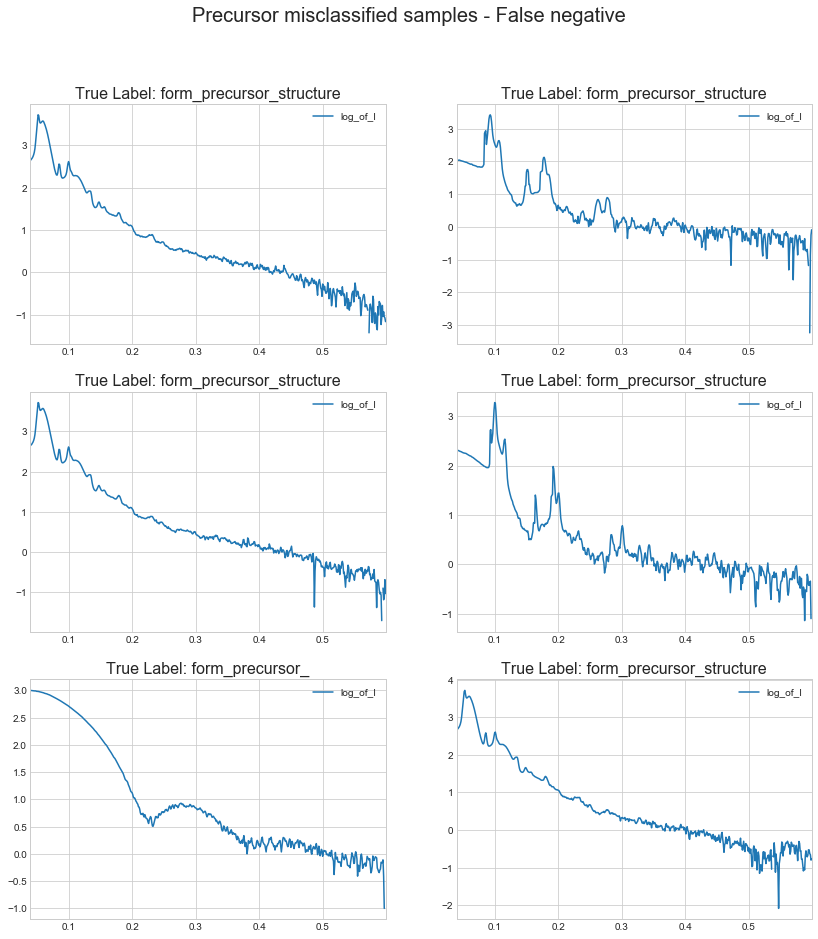

In [198]:
false_negative = difference[difference['precursor'] == True]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))
st = fig.suptitle("Precursor misclassified samples - False negative", fontsize=20)
st.set_y(0.97)

for n in range(6): 
    d = false_negative.iloc[n]
    ex = d.iloc[0]
    file_name = d.iloc[1]
    str_label = d.iloc[-7]
    df_v = pd.read_csv('../2016_saxs_data/' + ex + '/'+ file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    #axes[n%2, n//2].set_title(file_name + " " + str_label);
    axes[n%3, n%2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%3, n%2].xaxis.label.set_visible(False)

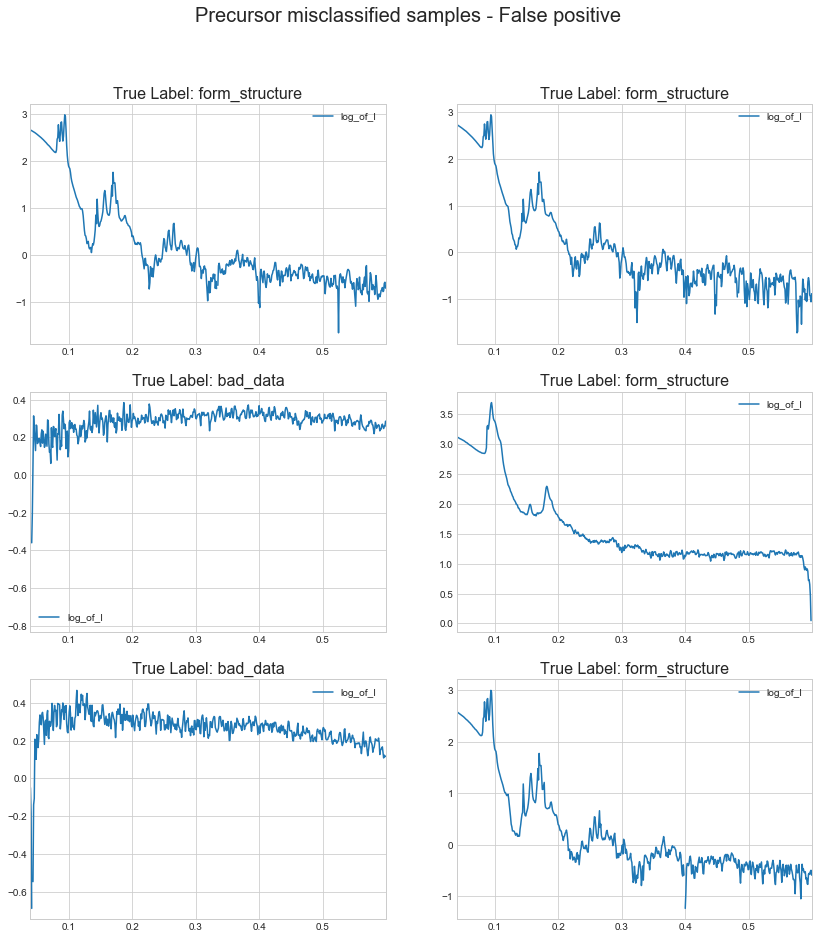

In [199]:
false_positive = difference[difference['precursor'] == False]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))
st = fig.suptitle("Precursor misclassified samples - False positive", fontsize=20)
st.set_y(0.97)

for n in range(6): 
    d = false_positive.iloc[n]
    ex = d.iloc[0]
    file_name = d.iloc[1]
    str_label = d.iloc[-7]
    df_v = pd.read_csv('../2016_saxs_data/' + ex + '/'+ file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    #axes[n%2, n//2].set_title(file_name + " " + str_label);
    axes[n%3, n%2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%3, n%2].xaxis.label.set_visible(False)

In [206]:
# to train the model on all avalible data 
all_data = train_good.append(hold_out[hold_out['bad_data']==False])
scaler = preprocessing.StandardScaler()
scaler.fit(all_data[features])
log = linear_model.SGDClassifier(alpha= 0.01,loss= 'log', l1_ratio= 0.95, penalty= 'l1')
log.fit(scaler.transform(all_data[features]), all_data['precursor'])

# save the scaler and model
scalers['precursor_scattering'] = scaler.__dict__
models['precursor_scattering'] = log.__dict__

## Structure Label

In [143]:
cv=LeavePGroupsOut(n_groups=2).split(train_good[features], train_good[['structure']], groups=train_good['experiment'])

scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
clf = GridSearchCV(svc, parameters2, cv=cv)
    
clf.fit(scaler.transform(train_good[features]), train_good['structure'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.001, 'l1_ratio': 0, 'penalty': 'l1'}
Training score:  0.969


In [144]:
test_scores_by_ex = []
training_score = []
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        print("Testing on: ", experiments[i], 'and', experiments[j])
        tr = train_good[(train_good['experiment']!= experiments[i]) & (train_good['experiment']!= experiments[j])]
        test = train_good[(train['experiment']== experiments[i]) | (train_good['experiment']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0, penalty= 'l1')

        scores = cross_val_score(log, scaler.transform(tr[features]), tr['structure'], cv=5)
        print("cross validation score: ", scores.mean())
        training_score.append(scores.mean())

        log.fit(scaler.transform(tr[features]), tr['structure'])
        test_score = log.score(scaler.transform(test[features]), test['structure'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        count +=1
        print()
        
print("Average training score: ", sum(training_score)/count)
print("Average testing score: ", sum(test_scores_by_ex)/count)

Testing on:  R1 and R12
cross validation score:  0.974307494066
test score:  0.960829493088

Testing on:  R1 and R13
cross validation score:  0.971490849398
test score:  0.967213114754

Testing on:  R1 and R2
cross validation score:  0.971365332322
test score:  0.959420289855

Testing on:  R1 and R3
cross validation score:  0.970915344806
test score:  0.96978021978

Testing on:  R1 and R4
cross validation score:  0.969711553785
test score:  0.968390804598

Testing on:  R1 and R5
cross validation score:  0.988280826975
test score:  0.921375921376

Testing on:  R1 and R6
cross validation score:  0.969390005018
test score:  0.966463414634

Testing on:  R1 and R7
cross validation score:  0.971458156342
test score:  0.960784313725

Testing on:  R1 and Reaction_A
cross validation score:  0.970745129366
test score:  0.96699669967

Testing on:  R1 and Reaction_B
cross validation score:  0.972536276584
test score:  0.962328767123

Testing on:  R1 and Reaction_C
cross validation score:  0.970530

Testing on:  R7 and Reaction_A
cross validation score:  0.967873673384
test score:  0.985611510791

Testing on:  R7 and Reaction_B
cross validation score:  0.968107812067
test score:  0.96875

Testing on:  R7 and Reaction_C
cross validation score:  0.968339850693
test score:  0.979865771812

Testing on:  R7 and Reaction_D
cross validation score:  0.96801095865
test score:  0.984962406015

Testing on:  R7 and Reaction_E
cross validation score:  0.968259168259
test score:  0.97520661157

Testing on:  R7 and Reaction_G
cross validation score:  0.96845384403
test score:  0.973214285714

Testing on:  R7 and Reaction_H
cross validation score:  0.968172240037
test score:  0.976

Testing on:  Reaction_A and Reaction_B
cross validation score:  0.968183567518
test score:  0.992

Testing on:  Reaction_A and Reaction_C
cross validation score:  0.967716424234
test score:  1.0

Testing on:  Reaction_A and Reaction_D
cross validation score:  0.966032514701
test score:  1.0

Testing on:  Reaction_A an

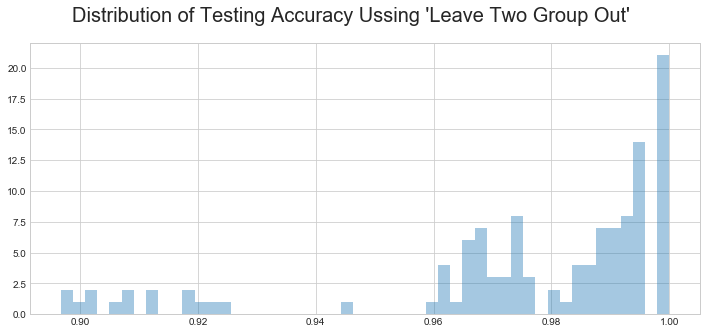

In [145]:
plt.figure(figsize=(12,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy Ussing 'Leave Two Group Out' ", fontsize=20)

In [146]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0, penalty= 'l1')

log.fit(scaler.transform(train_good[features]), train_good['structure'])
hold_out_score = log.score(scaler.transform(test_good[features]), test_good['structure'])
print("hold out score: ", hold_out_score)

hold out score:  0.994652406417


In [147]:
scalers['diffraction_peaks'] = scaler
models['diffraction_peaks'] = log

In [148]:
test_good['structure_pred'] = log.predict(scaler.transform(test_good[features]))

pr = log.predict_proba(scaler.transform(test_good[features]))[ : , 1]
formated_pr = list(map(lambda x: "{0:.16f}".format(x), pr))

test_good['structure_prob_true'] = pd.to_numeric(formated_pr)

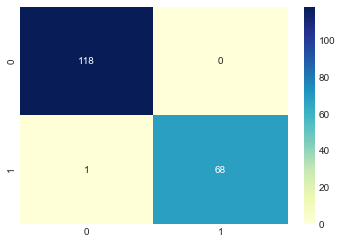

In [150]:
cnf_matrix = confusion_matrix(test_good['structure'], test_good['structure_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g', cmap="YlGnBu")

We have 1 false negative.

In [207]:
# to train the model on all avalible data 
all_data = train_good.append(hold_out[hold_out['bad_data']==False])
scaler = preprocessing.StandardScaler()
scaler.fit(all_data[features])
log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0, penalty= 'l1')
log.fit(scaler.transform(all_data[features]), all_data['structure'])

# save the scaler and model
scalers['diffraction_peaks'] = scaler.__dict__
models['diffraction_peaks'] = log.__dict__

In [208]:
with open('scalers_and_models.yml', 'w') as yaml_file:
    yaml.dump(scalers_and_models, yaml_file)

In [209]:
with open('scalers_and_models.yml') as info:
      s_and_m = yaml.load(info)

In [210]:
s_and_m

{'models': {'bad_data': {'C': 1.0,
   '_expanded_class_weight': array([ 1.,  1.]),
   'alpha': 0.001,
   'average': False,
   'class_weight': None,
   'classes_': array([False,  True], dtype=bool),
   'coef_': array([[ 1.64268707, -7.82259498,  3.61217901,  1.06955799,  0.        ]]),
   'epsilon': 0.1,
   'eta0': 0.0,
   'fit_intercept': True,
   'intercept_': array([-9.21916533]),
   'l1_ratio': 0.95,
   'learning_rate': 'optimal',
   'loss': 'log',
   'loss_function_': <sklearn.linear_model.sgd_fast.Log at 0x1a2317b648>,
   'max_iter': 5,
   'n_iter_': 5,
   'n_jobs': 1,
   'penalty': 'elasticnet',
   'power_t': 0.5,
   'random_state': None,
   'shuffle': True,
   't_': 9731.0,
   'tol': None,
   'verbose': 0,
   'warm_start': False},
  'diffraction_peaks': {'C': 1.0,
   '_expanded_class_weight': array([ 1.,  1.]),
   'alpha': 0.001,
   'average': False,
   'class_weight': None,
   'classes_': array([False,  True], dtype=bool),
   'coef_': array([[ 0.        ,  7.13876993,  8.973443

In [212]:
s_and_m['models']['bad_data']

{'C': 1.0,
 '_expanded_class_weight': array([ 1.,  1.]),
 'alpha': 0.001,
 'average': False,
 'class_weight': None,
 'classes_': array([False,  True], dtype=bool),
 'coef_': array([[ 1.64268707, -7.82259498,  3.61217901,  1.06955799,  0.        ]]),
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'intercept_': array([-9.21916533]),
 'l1_ratio': 0.95,
 'learning_rate': 'optimal',
 'loss': 'log',
 'loss_function_': <sklearn.linear_model.sgd_fast.Log at 0x1a2317b648>,
 'max_iter': 5,
 'n_iter_': 5,
 'n_jobs': 1,
 'penalty': 'elasticnet',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 't_': 9731.0,
 'tol': None,
 'verbose': 0,
 'warm_start': False}

## Results

### Supervised Learning using Logistic Regression  vs The Best Result From Unsupervised Classifiers

|            | feature set | average accuracy on data from experiments not used for training 
| ------------- | ------------- 
| bad_data  | analytical features| 0.973 
| form  |  analytical features  | 0.975 
| precursor | analytical features  | 0.764 
| structure | analytical features | 0.975 

We got very large variance of accuracy for precursor (forom 0.39 to 0.96). I think, it is possible to find a better model for the "precursor" label. 